# Runner

## Import data

In [ ]:
!pip install -q networkx

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.co m/rusty1s/pytorch_geometric.git

In [ ]:
import os, sys

from tqdm import tqdm
from typing import List, Dict

import pandas as pd
import numpy as np

import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio

pio.templates.default = 'seaborn'

sys.path.append(os.path.abspath('..'))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
from src.utils import CONNECTION_DIR, DATA_FOLDERS, FILES, extract_study_phase

In [ ]:
unwanted_features = ['pars_bodypart_petct', 'pars_region_petct', 'pars_subregion_petct', 'pars_laterality_petct',
                     'pars_classification_petct', 'roi_id', 'roi_name', 'lesion_label_id', 'study_name',
                     'n_days_to_treatment_start', 'n_days_to_treatment_end', 'pseudorecist', 'is_malignant',
                     'brain_seg_exists', 'bones_seg_exists', 'spleen_seg_exists', 'aorta_seg_exists',
                     'heart_seg_exists', 'kidney_right_seg_exists', 'kidney_left_seg_exists', 'lung_right_seg_exists', 
                     'lung_left_seg_exists', 'liver_seg_exists', 'death_event_observed',
                     'n_imgs_before_treatment', 'n_imgs_during_treatment', 'n_imgs_after_treatment_end', 'n_imgs_after_treatment_start']

In [ ]:
CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

In [ ]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['lesions']))
lesions['study_phase'] = lesions.study_name.apply(extract_study_phase)

progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['progression']))

studies = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['studies']))
studies.rename(columns={'is_malignant': 'malignant_lesions'}, inplace=True)
studies.drop(columns=['n_days_to_treatment_start', 'n_days_to_treatment_end'], inplace=True)

patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['patients']))
patients['age_at_treatment_start_in_years'] = \
    patients.age_at_treatment_start_in_years.apply(lambda a: 90 if a == '90 or older' else int(a))

blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['blood']))
blood.drop(columns=['n_days_to_treatment_start', 'n_days_to_treatment_end'], inplace=True)
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)

In [ ]:
p1lesions = lesions[(lesions.pars_classification_petct != 'benign') & (lesions.study_name == 'post-01')].copy()
p1lesions.drop(columns=['study_phase', *list(set(p1lesions.columns) & set(unwanted_features))], inplace=True)

In [ ]:
preprocess(p1patients[['gpcr_id', *features_numerical]], 
                       features_numerical=features_numerical, training=True)

(       gpcr_id   vol_ccm  max_suv_val  mean_suv_val  min_suv_val  sd_suv_val
 0   34610002.0  1.954659    -0.431232     -0.673149    -0.635526   -0.329402
 1   34610004.0 -0.534627    -0.151955     -0.107049    -0.215143   -0.294900
 2   34610005.0 -0.771544    -0.888310     -0.991939    -0.145079   -0.554386
 3   34610006.0 -0.540825    -0.456384     -0.349991     0.275303   -0.225816
 4   34610007.0  0.058253     2.749235      1.221197    -0.054997    0.763411
 ..         ...       ...          ...           ...          ...         ...
 90  34610144.0  0.153041    -0.583013     -0.387800     0.175212   -0.011824
 91  34610145.0  0.897134    -0.270778      0.180943     0.315340    0.130195
 92  34610146.0 -0.473181    -0.447711     -0.474412    -0.445353   -0.305010
 93  34610148.0 -0.397200    -0.016653      0.076365    -0.355271   -0.044400
 94  34610149.0 -0.499255     2.849844      2.039214    -0.305225    2.163718
 
 [95 rows x 6 columns],
 SimpleImputer(strategy='most_frequent

In [ ]:
p1patients = p1lesions.groupby('gpcr_id').agg({
        'vol_ccm': np.sum,
        'max_suv_val': np.mean,
        'mean_suv_val': np.mean,
        'min_suv_val': np.mean,
        'sd_suv_val': np.mean,
        'assigned_organ': pd.Series.tolist
    }).reset_index()

features_numerical = ['vol_ccm', 'max_suv_val', 'mean_suv_val', 'min_suv_val', 'sd_suv_val']

mlb = MultiLabelBinarizer()

processed_radiomics = \
    pd.DataFrame(
        np.concatenate((
            preprocess(p1patients[['gpcr_id', *features_numerical]], 
                       features_numerical=features_numerical, training=True)[0],
            mlb.fit_transform(p1patients['assigned_organ'])), axis=1),
        columns=['gpcr_id', *features_numerical, *mlb.classes_]
    )

processed_radiomics

,gpcr_id,vol_ccm,max_suv_val,mean_suv_val,min_suv_val,sd_suv_val,bones_abdomen,bones_lowerlimb,bones_thorax,kidney,liver,lung,lymphnode_abdomen,lymphnode_lowerlimb,lymphnode_thorax,other_abdomen,other_lowerlimb,other_thorax,spleen
0,34610002.0,1.954659,-0.712931,-0.673149,-0.802001,-0.329402,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
1,34610004.0,-0.534627,-0.248083,-0.107049,-0.004678,-0.294900,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,34610005.0,-0.771544,-0.947660,-0.991939,-1.078850,-0.554386,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34610006.0,-0.540825,-0.147784,-0.349991,-0.326479,-0.225816,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,34610007.0,0.058253,1.338696,1.221197,1.319623,0.763411,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,34610144.0,0.153041,-0.370559,-0.387800,-0.500623,-0.011824,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
91,34610145.0,0.897134,0.139723,0.180943,0.181946,0.130195,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
92,34610146.0,-0.473181,-0.486652,-0.474412,-0.535565,-0.305010,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93,34610148.0,-0.397200,0.044919,0.076365,0.151244,-0.044400,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
patients_full = blood.merge(patients[['gpcr_id', 'age_at_treatment_start_in_years']], on='gpcr_id', how='outer')

# Some features are removed altogether as they have too many missing values
features_to_be_removed = ['proteine_c_reacsang_mgl', 'gfr_cal_mlmin173m2', 'calcium_sang_mmoll', 'albumine_sang_gl']

patients_full.drop(columns=features_to_be_removed, inplace=True)

features_categorical = ['NRAS_MUT_TYPE', 'BRAF_MUT_TYPE', 'BRAF_MUTATION', 'NRAS_MUTATION', 
                        'immuno_therapy_type', 'has_brain_mets', 'sex', 'concomittant_tvec', 
                        'concomittant_LAG3', 'prior_targeted_therapy', 'prior_treatment', 'nivo_maintenance']
features_numerical = ['bmi', 'performance_score_ecog', 'asat_sang_ul', 'bili_totale_sang_umoll', 'mono_absolus_gl', 
                      'alat_sang_ul', 'plaquettes_sang_gl', 'lympho_absolus_gl', 
                      'potassium_sang_mmoll', 'hemoglobine_sang_gl',
                      'ldh_sang_ul', 'creatinine_sang_umoll', 'pal_sang_ul', 'neutro_absolus_gl', 'eosini_absolus_gl', 
                      'baso_absolus_gl', 'ggt_sang_ul', 'leucocytes_sang_gl', 'eGFRCKD2', 'eGFRCG', 
                      'X67', 'age_at_treatment_start_in_years']

In [ ]:
processed_patients, impc, imp, estc, estn = preprocess(
    patients_full, features_categorical=features_categorical, features_numerical=features_numerical,
    training=True
)

processed_patients

,gpcr_id,x0_G12C,x0_G12D,x0_Q61H,x0_Q61K,x0_Q61L,x0_Q61R,x0_nan,x1_G464R,x1_G466E,...,pal_sang_ul,neutro_absolus_gl,eosini_absolus_gl,baso_absolus_gl,ggt_sang_ul,leucocytes_sang_gl,eGFRCKD2,eGFRCG,X67,age_at_treatment_start_in_years
0,34610001.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.555928,1.987882,-1.065276,-1.099884,-0.264476,3.392245,0.502390,0.182913,-1.422318,0.154654
1,34610096.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.968606,-0.248220,0.254290,-0.119693,-0.238565,-0.139437,0.010449,-0.714566,-0.010694,0.154654
2,34610002.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.190899,-0.044938,-0.099740,0.424857,-0.497676,-0.123457,1.040500,1.047383,-0.010694,-1.672306
3,34610097.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.620345,0.284009,0.994534,-1.099884,-0.147876,0.100270,0.452850,-0.045407,-0.363600,0.666203
4,34610003.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.260019,-0.203867,-0.292847,-0.010783,-0.368121,-0.155418,0.206506,-0.101543,-0.010694,0.154654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,34610091.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.054495,-0.203867,-0.292847,-0.010783,-0.588365,-0.155418,0.296415,-0.101543,1.400929,0.520046
142,34610092.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.732410,0.690573,-1.065276,0.860498,-0.627232,0.451840,-0.010046,-0.101543,0.342212,0.154654
143,34610093.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.233844,-0.569775,-0.357216,-1.099884,-0.368121,-0.698754,-0.245051,-0.426600,-3.186847,1.543144
144,34610094.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.169427,-1.364423,-0.936538,-1.099884,-0.290388,-1.753464,0.450060,-1.165668,-0.363600,1.031595


In [ ]:
labels = progression[(progression.study_name == 'post-01')].set_index('gpcr_id').loc[processed.gpcr_id].prediction_score.dropna()
labels.value_counts()

PD     43
NPD    42
Name: prediction_score, dtype: int64

In [ ]:
processed = processed_radiomics.merge(processed_patients, on='gpcr_id')

X = np.array(processed[processed.gpcr_id.isin(labels.index)].drop(columns='gpcr_id'))
y = (labels.values == 'PD').astype(int)

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=27)

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=.01, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(penalty='l2', solver='liblinear')]

In [ ]:
scores = []

for name, clf in tqdm(zip(names, classifiers), total=len(names)):

    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

100%|██████████| 10/10 [00:00<00:00, 19.07it/s]


In [ ]:
for method, score in list(zip(names, scores)):
    print(f'{method:<20} {score:,.4f}')

Nearest Neighbors    0.5517
Linear SVM           0.5172
RBF SVM              0.3448
Gaussian Process     0.4483
Decision Tree        0.4483
Random Forest        0.5172
Neural Net           0.4828
AdaBoost             0.5862
Naive Bayes          0.5862
Logistic Regression  0.6207


### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit_transform(X).shape, labels.values.shape

((85, 2), (85,))

In [ ]:
reduced = pd.DataFrame(np.concatenate((pca.fit_transform(X), labels.values.reshape(-1, 1)), axis=1), 
                       columns=['x', 'y', 'label'])

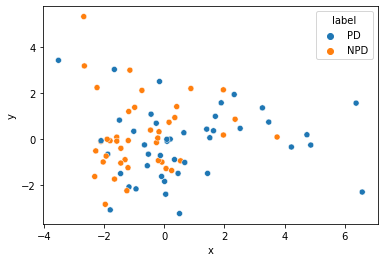

In [ ]:
sns.scatterplot(data=reduced, x='x', y='y', hue='label')

### For the sake of reference

In [ ]:
# diff = studies[['gpcr_id', 'study_name', 'malignant_lesions']].merge(lesions[lesions.is_malignant == True].groupby(by=['gpcr_id', 'study_name']).size().to_frame('lesions').reset_index(), on=['gpcr_id', 'study_name'])

# d = np.abs(diff.malignant_lesions - diff.lesions)

# sns.histplot(d)

In [ ]:
# print('Percent NaN:')
# print('\n '.join([ str(feature) + ': ' + str(blood[feature].isna().sum() / blood.shape[0]) + '%' for feature in blood.columns]))

In [ ]:
def preprocess(
    df: pd.DataFrame,
    features_categorical: List[str] = [], features_numerical: List[str] = [],
    training: bool = True, index: str = 'gpcr_id',
    imputer_categorical: BaseEstimator = SimpleImputer(strategy='most_frequent'), 
    imputer_numerical: BaseEstimator = SimpleImputer(strategy='median'),
    estimator_categorical: BaseEstimator = OneHotEncoder(drop='if_binary'),
    estimator_numerical: BaseEstimator = StandardScaler(),
):
    
    processed = df[[index]]
    columns = [index]
    
    if len(features_categorical) > 0:
        if training:
            imputer_categorical.fit(df[features_categorical])
            estimator_categorical.fit(df[features_categorical])
            
        processed = np.append(processed,
                  estimator_categorical.transform(
                      imputer_categorical.transform(df[features_categorical])
                  ).todense(),
                  axis=1)
        
        columns.extend(estimator_categorical.get_feature_names())

    if len(features_numerical) > 0:
        if training:
            imputer_numerical.fit(df[features_numerical])
            estimator_numerical.fit(df[features_numerical])
            
        processed = np.append(processed,
                  estimator_numerical.transform(
                      imputer_numerical.transform(df[features_numerical])),
                  axis=1)
                       
        columns.extend(features_numerical)
    
    processed = pd.DataFrame(processed, columns=columns)
    
    return processed, \
        imputer_categorical, imputer_numerical, estimator_categorical, estimator_numerical

In [ ]:
@interact(feature=blood.columns)
def printer(feature):
    print(blood[feature].value_counts())
    sns.histplot(blood, x=feature)

interactive(children=(Dropdown(description='feature', options=('gpcr_id', 'sex', 'bmi', 'has_brain_mets', 'per…

In [ ]:
bmi_imputer.transform(blood[['bmi']]).ravel()

array([28.4 , 19.61, 24.62, 20.87, 25.61, 27.7 , 29.26, 26.18, 30.74,
       30.82, 34.42, 23.71, 26.4 , 39.52, 20.7 , 30.47, 30.7 , 24.44,
       32.33, 27.96, 22.3 , 19.38, 32.39, 23.57, 28.27, 23.74, 31.97,
       31.16, 25.  , 21.63, 19.1 , 25.59, 33.06, 27.34, 20.94, 43.28,
       31.56, 26.03, 23.67, 22.39, 22.15, 22.22, 21.67, 25.88, 26.53,
       18.96, 26.78, 29.98, 23.89, 29.75, 36.11, 33.49, 35.49, 23.18,
       24.86, 25.76, 27.53, 21.88, 26.7 , 30.27, 25.61, 26.12, 25.46,
       23.6 , 19.77, 31.44, 37.72, 28.38, 21.08, 36.01, 21.39, 32.39,
       24.16, 19.49, 30.79, 22.64, 22.53, 21.16, 32.37, 22.22, 24.86,
       28.03, 23.91, 26.12, 25.47, 23.45, 26.31, 20.  , 27.34, 19.61,
       33.33, 20.52, 31.56, 22.76, 23.74, 29.07, 25.52, 25.28, 23.88,
       29.21, 22.96, 25.4 , 24.39, 19.24, 20.07, 31.05, 21.88, 27.12,
       25.24, 37.96, 32.32, 28.7 , 25.25, 25.86, 24.45, 29.81, 31.38,
       26.08, 31.3 , 28.07, 22.66, 16.56, 30.42, 27.92, 25.7 , 32.47,
       27.46, 22.1 ,

In [ ]:
lesion_key_features = ['gpcr_id', 'study_name']
lesions = lesions \
    .merge(progression, on=lesion_key_features) \
    .merge(studies, on=lesion_key_features) \
    .merge(patients, on='gpcr_id') \
    .merge(blood, on='gpcr_id')

In [ ]:
lesions

,gpcr_id,study_name,vol_ccm,max_suv_val,mean_suv_val,min_suv_val,sd_suv_val,is_malignant,assigned_organ,prediction_score,...,NRAS_MUT_TYPE,BRAF_MUTATION,BRAF_MUT_TYPE,concomittant_tvec,concomittant_LAG3,prior_targeted_therapy,prior_treatment,immuno_therapy_type,nivo_maintenance,study_phase
0,34610002,pre-01,1.00,5.58,3.37,2.36,0.92,True,other_lowerlimb,PD,...,NaN,n,NaN,0,0,0,0,ipinivo,0,-1
1,34610002,pre-01,0.61,5.72,3.50,2.46,0.97,True,other_lowerlimb,PD,...,NaN,n,NaN,0,0,0,0,ipinivo,0,-1
4,34610002,pre-01,1.83,2.79,1.56,1.18,0.33,True,lymphnode_abdomen,PD,...,NaN,n,NaN,0,0,0,0,ipinivo,0,-1
6,34610002,pre-01,0.78,3.07,1.90,1.39,0.51,True,other_abdomen,PD,...,NaN,n,NaN,0,0,0,0,ipinivo,0,-1
7,34610002,pre-01,0.83,3.48,2.30,1.67,0.51,True,lymphnode_abdomen,PD,...,NaN,n,NaN,0,0,0,0,ipinivo,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20815,34610149,post-02,0.98,18.38,11.83,7.77,2.90,True,lung,NaN,...,G12C,n,NaN,0,0,0,0,ipinivo,0,2
20816,34610149,post-02,3.77,6.15,3.47,2.59,0.78,True,lung,NaN,...,G12C,n,NaN,0,0,0,0,ipinivo,0,2
20817,34610149,post-02,1.47,27.32,17.10,11.53,4.52,True,lung,NaN,...,G12C,n,NaN,0,0,0,0,ipinivo,0,2
20818,34610149,post-02,0.54,6.61,3.90,2.81,0.97,True,lung,NaN,...,G12C,n,NaN,0,0,0,0,ipinivo,0,2


In [ ]:
lesions.shape

(20892, 86)

In [ ]:
lesions.columns

Index(['gpcr_id', 'study_name', 'roi_id', 'roi_name', 'lesion_label_id',
       'pars_bodypart_petct', 'pars_region_petct', 'pars_subregion_petct',
       'pars_laterality_petct', 'pars_classification_petct', 'vol_ccm',
       'max_suv_val', 'mean_suv_val', 'min_suv_val', 'sd_suv_val',
       'is_malignant', 'assigned_organ', 'n_days_to_treatment_start_x',
       'n_days_to_treatment_end_x', 'prediction_score', 'pseudorecist',
       'is_before_treatment', 'is_during_treatment', 'is_after_treatment_end',
       'nth_before_treatment', 'nth_after_treatment_start',
       'nth_during_treatment', 'nth_after_treatment_end', 'malignant_lesions',
       'brain_seg_exists', 'bones_seg_exists', 'spleen_seg_exists',
       'aorta_seg_exists', 'heart_seg_exists', 'kidney_right_seg_exists',
       'kidney_left_seg_exists', 'lung_right_seg_exists',
       'lung_left_seg_exists', 'liver_seg_exists',
       'age_at_treatment_start_in_years', 'duration_treatment_in_days',
       'death_event_observed

## Evaluating the given labels

In [ ]:
progression[~(progression.prediction_score.isna()) & (progression.pseudorecist.isna())]

,gpcr_id,study_name,n_days_to_treatment_start,n_days_to_treatment_end,prediction_score,pseudorecist
0,34610001,pre-02,-43.0,-106.0,PD,NaN
1,34610001,pre-01,-7.0,-70.0,PD,NaN
2,34610001,post-01,87.0,24.0,NPD,NaN
7,34610096,pre-01,-29.0,-92.0,PD,NaN
11,34610096,post-04,269.0,206.0,NPD,NaN
...,...,...,...,...,...,...
519,34610093,pre-01,-9.0,-114.0,PD,NaN
522,34610094,pre-01,-80.0,-569.0,PD,NaN
526,34610094,post-04,402.0,-87.0,NPD,NaN
527,34610095,pre-01,-18.0,-102.0,PD,NaN


In [ ]:
cm = confusion_matrix(progression[['prediction_score', 'pseudorecist']].dropna().prediction_score, 
                      progression[['prediction_score', 'pseudorecist']].dropna().pseudorecist,
                      labels=['PD', 'NPD'])

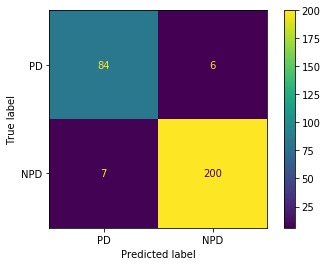

In [ ]:
CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot()

plt.show()

In [ ]:
CM.figure_.savefig('cm.png', dpi=200)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7360151b-146e-499a-b01b-835ca18c34fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>